In [1]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, LabelEncoder
from sklearn.model_selection import GridSearchCV
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport
pd.set_option('display.max_columns', None)
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.linear_model import Ridge
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from numpy import save

In [2]:
df = pd.read_csv('/Users/architmatta/Documents/Columbia/Fall 2021/Capstone/Data/full_data_inner.csv', low_memory = False)

In [3]:
df_subset = df[['utilization_type', 'state',
       'package_size', 'year', 'quarter', 'suppression_used',
       'units_reimbursed', 'Submission', 'Active Ingredients',
       'Company', 'Submission Classification *', 'year_y',
       'month', 'adverse_affects', 'NDA']]

In [4]:
df_subset.columns = ['utilization_type', 'state',
       'package_size', 'year', 'quarter', 'suppression_used',
       'units_reimbursed', 'submission', 'active_ingredients',
       'company', 'submission_classification', 'approval_year',
       'approval_month', 'adverse_affects', 'NDA']

In [5]:
df_subset.shape

(3544366, 15)

In [6]:
df_subset = df_subset[df_subset['units_reimbursed'] >= df_subset['adverse_affects']]

In [7]:
df_subset.shape

(1991148, 15)

In [11]:
3544366-1991148

1553218

In [12]:
df_subset['approval_quarter'] = df_subset['approval_month']//4 + 1

In [13]:
df_subset = df_subset.dropna(subset=['approval_year', 'approval_month', 'approval_quarter'])

In [14]:
df_subset.shape

(1991148, 16)

In [15]:
df_subset['time_since_approval'] = df_subset['year'] - df_subset['approval_year']
df_subset = df_subset[df_subset['time_since_approval'] >= 0]
df_subset['rate'] = df_subset['adverse_affects']/df_subset['units_reimbursed']

In [16]:
df_subset.shape

(1724320, 18)

In [17]:
1991148-1724320

266828

In [9]:
df_subset_2 = df_subset.copy()
#df_subset_2 = df_subset[df_subset['NDA'].isin(set((df_subset[['NDA']][df_subset['approval_year'] > 2015].values).ravel()))]
df_plot = df_subset_2[['time_since_approval', 'rate']].groupby('time_since_approval').median('rate').reset_index()
df_plot.head()

,time_since_approval,rate
0,0,0.009237
1,1,0.007982
2,2,0.010345
3,3,0.010282
4,4,0.007692


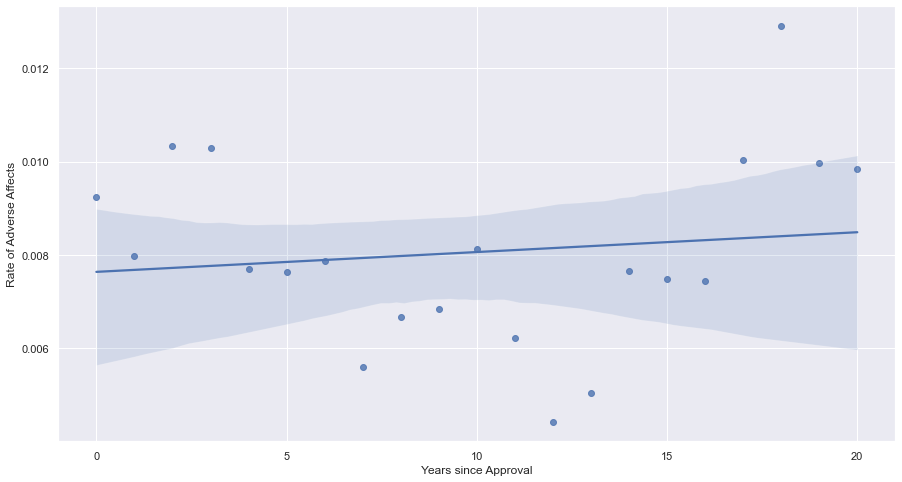

In [10]:
sns.regplot(x = 'time_since_approval', y = 'rate', data = df_plot)
plt.xticks(np.arange(0, 21, 5))
plt.gcf().set_size_inches(15,8)
plt.xlabel('Years since Approval');
plt.ylabel('Rate of Adverse Affects')
fig = plt.show();

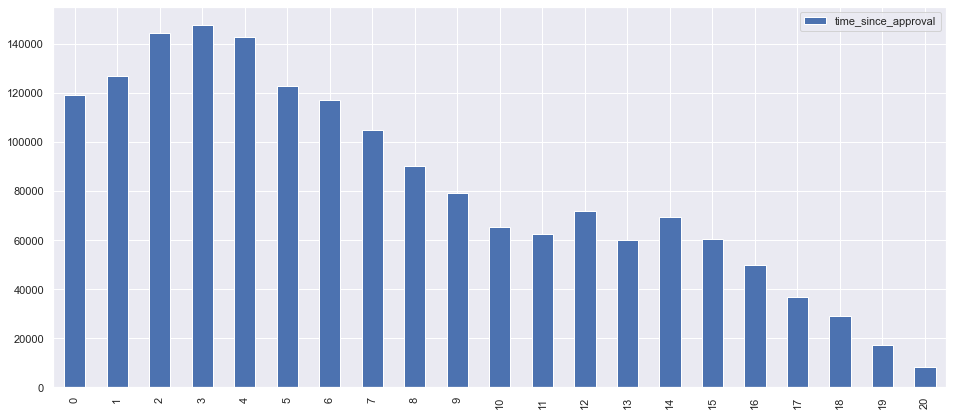

In [11]:
pd.DataFrame(df_subset['time_since_approval'].value_counts()).reset_index().sort_values(by = 'index').reset_index().drop(columns = ['level_0', 'index']).plot(kind = 'bar', figsize=(16,7));

In [12]:
len(set(df_subset['NDA']))

4709

In [13]:
df_model = df_subset[['utilization_type', 'state', 'package_size',
       'suppression_used', 'submission', 'approval_month',
       'active_ingredients', 'company', 'submission_classification', 'time_since_approval', 'rate']]

In [14]:
df = df_model.copy()

In [15]:
out = []
for i in df['active_ingredients'].ravel():
    out+=i.split(";")
out2 = []
for i in out:
    out2+=i.split(",")
out3 = []
for i in out2:
    out3.append(i.strip())
ingredients = set(out3)

In [16]:
arr = np.zeros((df.shape[0], len(ingredients)))

In [17]:
for i, ingredient in enumerate(df['active_ingredients'].ravel()):
    for j, label in enumerate(ingredients):
        if label in ingredient:
            arr[i, j] = 1

In [18]:
categorical_cols = ['utilization_type', 'state', 'package_size', 'suppression_used', 'submission', 'company', 'submission_classification', 'time_since_approval']
df_ohe = df[categorical_cols]
df_ohe = df_ohe.apply(LabelEncoder().fit_transform)

In [38]:
X = np.hstack((arr, df_ohe.to_numpy(), df['approval_month'].to_numpy().reshape(-1, 1)))
y = df['rate'].to_numpy()

In [65]:
columns = (list(ingredients) + list(df_ohe.columns) + ['approval_month'])

In [20]:
X.shape

(1724320, 1440)

In [21]:
pca = PCA(n_components = 100)
pca.fit(X)
X_reduced = pca.transform(X)

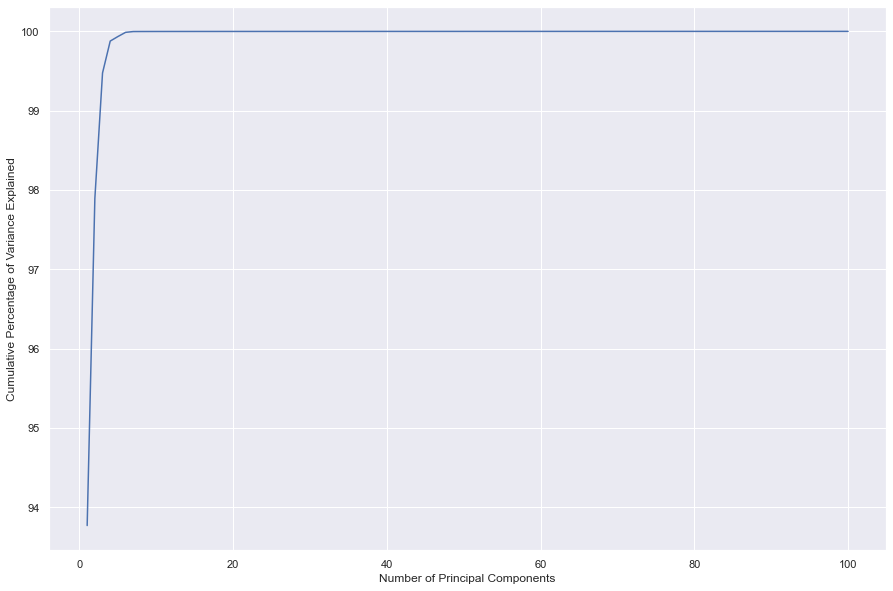

In [22]:
df_temp = pd.DataFrame({'Number of Principal Components': [i for i in range (1,101)], 'Cumulative Percentage of Variance Explained': np.cumsum(pca.explained_variance_ratio_*100)})
plt.gcf().set_size_inches((15, 10))
sns.lineplot(data = df_temp, x = 'Number of Principal Components', y = 'Cumulative Percentage of Variance Explained');

In [34]:
np.cumsum(pca.explained_variance_ratio_*100)

array([93.76800314, 97.8914022 , 99.47479822, 99.87661825, 99.93381696,
       99.98667312, 99.99664026, 99.9970845 , 99.99729358, 99.99747302,
       99.99755675, 99.99763481, 99.99769118, 99.9977366 , 99.99777813,
       99.99781592, 99.9978513 , 99.99788465, 99.99791716, 99.9979493 ,
       99.99798069, 99.99801142, 99.9980411 , 99.99806997, 99.99809696,
       99.99812338, 99.99814918, 99.99817309, 99.99819633, 99.99821773,
       99.99823741, 99.99825682, 99.99827546, 99.99829364, 99.99831066,
       99.99832753, 99.9983441 , 99.99836035, 99.99837648, 99.99839207,
       99.9984075 , 99.99842286, 99.99843814, 99.99845312, 99.99846788,
       99.99848261, 99.99849723, 99.9985118 , 99.99852577, 99.99853944,
       99.99855306, 99.99856655, 99.99857989, 99.99859305, 99.99860592,
       99.99861824, 99.9986302 , 99.99864206, 99.99865382, 99.99866529,
       99.99867671, 99.99868809, 99.99869934, 99.99871046, 99.99872148,
       99.99873247, 99.99874329, 99.99875398, 99.99876442, 99.99

In [39]:
X = X_reduced[:, :7]
y = pd.qcut(y, 5, labels = False)

In [41]:
save('X.npy', X)

In [42]:
save('y.npy', y)

In [52]:
save('PCA_Components.npy', pca.components_)

In [66]:
save('Columns.npy', columns)